# Обучение нейронной сети на Stroke Prediction Dataset

## Подключение необходимых библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

## Загрузка данных

In [2]:
data_raw = pd.read_csv('healthcare-dataset-stroke-data.csv')
data_raw.shape

(5110, 12)

In [3]:
data_raw

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Обработка и подготовка данных

In [4]:
pd.Series(data_raw.stroke).value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Всего 4861 объект первого класса и 249 объектов второго класса. Очевидно, что данные сильно несбалансированы, и для успешного обучения нейронной сети будет необходимо их обработать.

In [5]:
data_raw.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Заполним пропущенные значения медианой.

In [6]:
data_raw.fillna(data_raw.median(axis = 0), axis=0 , inplace=True)

In [7]:
data_raw.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Обработаем категориальные признаки. Приведём их к типу category.

In [8]:
categorical_columns = [c for c in data_raw.columns if data_raw[c].dtype.name == 'object']

In [9]:
data_raw[categorical_columns] = data_raw[categorical_columns].astype('category')

In [10]:
categorical_columns

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

У признака "smoking_status" есть ещё одно значение "неизвестно" ("Unknown"). Это пропущенные значения, и их необходимо обработать.

In [11]:
data_raw.loc[(data_raw['smoking_status']=='Unknown'), 'smoking_status'] = np.NaN

In [12]:
data_raw.isna().sum()

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                     0
smoking_status       1544
stroke                  0
dtype: int64

Пропущенные значения заполним модой.

In [13]:
data_raw['smoking_status'].fillna(data_raw['smoking_status'].mode().iloc[0], inplace=True)

In [14]:
data_raw.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## Нормализация признаков

Закодируем бинарные категориальные признаки как числовые.

In [15]:
data_raw['ever_married'] = pd.factorize(data_raw['ever_married'])[0]

Теперь 0 для признака "состояли ли в браке" - "да", а 1 - "нет".

In [16]:
data_raw['Residence_type'] = pd.factorize(data_raw['Residence_type'])[0]

0 - место жительства "город", 1 - место жительства "селькая местность".

In [17]:
data_raw

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,0,Private,0,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,0,Self-employed,1,202.21,28.1,never smoked,1
2,31112,Male,80.0,0,1,0,Private,1,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,0,Private,0,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,0,Self-employed,1,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,0,Private,0,83.75,28.1,never smoked,0
5106,44873,Female,81.0,0,0,0,Self-employed,0,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,0,Self-employed,1,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,0,Private,1,166.29,25.6,formerly smoked,0


К небинарным категориальным признакам применим метод бинаризации.

In [18]:
work_type_dummies = pd.get_dummies(data_raw['work_type'])
data_raw = pd.concat((data_raw, work_type_dummies), axis=1)
data_raw = data_raw.drop(['work_type'], axis=1)

In [19]:
gender_dummies = pd.get_dummies(data_raw['gender'])
data_raw = pd.concat((data_raw, gender_dummies), axis=1)
data_raw = data_raw.drop(['gender'], axis=1)

In [20]:
smoking_status_dummies = pd.get_dummies(data_raw['smoking_status'])
data_raw = pd.concat((data_raw, smoking_status_dummies), axis=1)
data_raw = data_raw.drop(['smoking_status'], axis=1)

In [21]:
data_raw

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Govt_job,...,Private,Self-employed,children,Female,Male,Other,Unknown,formerly smoked,never smoked,smokes
0,9046,67.0,0,1,0,0,228.69,36.6,1,0,...,1,0,0,0,1,0,0,1,0,0
1,51676,61.0,0,0,0,1,202.21,28.1,1,0,...,0,1,0,1,0,0,0,0,1,0
2,31112,80.0,0,1,0,1,105.92,32.5,1,0,...,1,0,0,0,1,0,0,0,1,0
3,60182,49.0,0,0,0,0,171.23,34.4,1,0,...,1,0,0,1,0,0,0,0,0,1
4,1665,79.0,1,0,0,1,174.12,24.0,1,0,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,0,0,83.75,28.1,0,0,...,1,0,0,1,0,0,0,0,1,0
5106,44873,81.0,0,0,0,0,125.20,40.0,0,0,...,0,1,0,1,0,0,0,0,1,0
5107,19723,35.0,0,0,0,1,82.99,30.6,0,0,...,0,1,0,1,0,0,0,0,1,0
5108,37544,51.0,0,0,0,1,166.29,25.6,0,0,...,1,0,0,0,1,0,0,1,0,0


Стандартизуем числовые признаки.

In [22]:
data_stand = (data_raw - data_raw.mean(axis = 0))/data_raw.std(axis = 0)

In [23]:
data_stand

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Govt_job,...,Private,Self-employed,children,Female,Male,Other,Unknown,formerly smoked,never smoked,smokes
0,-1.298185,1.051331,-0.328570,4.184622,-0.723813,-0.983983,2.706111,1.004988,4.417948,-0.384073,...,0.864212,-0.436838,-0.394074,-1.189394,1.189873,-0.013989,NaN,2.184737,-1.432539,-0.427271
1,0.716301,0.785993,-0.328570,-0.238923,-0.723813,1.016078,2.121351,-0.098971,4.417948,-0.384073,...,-1.156897,2.288731,-0.394074,0.840600,-0.840261,-0.013989,NaN,-0.457631,0.697925,-0.427271
2,-0.255453,1.626231,-0.328570,4.184622,-0.723813,1.016078,-0.005028,0.472490,4.417948,-0.384073,...,0.864212,-0.436838,-0.394074,-1.189394,1.189873,-0.013989,NaN,-0.457631,0.697925,-0.427271
3,1.118254,0.255317,-0.328570,-0.238923,-0.723813,-0.983983,1.437217,0.719257,4.417948,-0.384073,...,0.864212,-0.436838,-0.394074,0.840600,-0.840261,-0.013989,NaN,-0.457631,-1.432539,2.339975
4,-1.646975,1.582008,3.042899,-0.238923,-0.723813,1.016078,1.501038,-0.631469,4.417948,-0.384073,...,-1.156897,2.288731,-0.394074,0.840600,-0.840261,-0.013989,NaN,-0.457631,0.697925,-0.427271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,-0.864005,1.626231,3.042899,-0.238923,-0.723813,-0.983983,-0.494609,-0.098971,-0.226305,-0.384073,...,0.864212,-0.436838,-0.394074,0.840600,-0.840261,-0.013989,NaN,-0.457631,0.697925,-0.427271
5106,0.394825,1.670454,-0.328570,-0.238923,-0.723813,-0.983983,0.420734,1.446571,-0.226305,-0.384073,...,-1.156897,2.288731,-0.394074,0.840600,-0.840261,-0.013989,NaN,-0.457631,0.697925,-0.427271
5107,-0.793642,-0.363806,-0.328570,-0.238923,-0.723813,1.016078,-0.511393,0.225723,-0.226305,-0.384073,...,-1.156897,2.288731,-0.394074,0.840600,-0.840261,-0.013989,NaN,-0.457631,0.697925,-0.427271
5108,0.048492,0.343763,-0.328570,-0.238923,-0.723813,1.016078,1.328127,-0.423665,-0.226305,-0.384073,...,0.864212,-0.436838,-0.394074,-1.189394,1.189873,-0.013989,NaN,2.184737,-1.432539,-0.427271


## Отбор признаков и разбиение объектов на обучающую и тестовую выборки

Для предсказания инсульта будем использовать все признаки, кроме идентификатора. Также исключим столбец значения статуса курения "неизвестно", которое было присвоено пропущенным значениям.

In [24]:
X = data_stand.drop(['stroke', 'id', 'Unknown'], axis=1)
y = data_raw['stroke']

In [25]:
X

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,Govt_job,Never_worked,Private,Self-employed,children,Female,Male,Other,formerly smoked,never smoked,smokes
0,1.051331,-0.328570,4.184622,-0.723813,-0.983983,2.706111,1.004988,-0.384073,-0.06575,0.864212,-0.436838,-0.394074,-1.189394,1.189873,-0.013989,2.184737,-1.432539,-0.427271
1,0.785993,-0.328570,-0.238923,-0.723813,1.016078,2.121351,-0.098971,-0.384073,-0.06575,-1.156897,2.288731,-0.394074,0.840600,-0.840261,-0.013989,-0.457631,0.697925,-0.427271
2,1.626231,-0.328570,4.184622,-0.723813,1.016078,-0.005028,0.472490,-0.384073,-0.06575,0.864212,-0.436838,-0.394074,-1.189394,1.189873,-0.013989,-0.457631,0.697925,-0.427271
3,0.255317,-0.328570,-0.238923,-0.723813,-0.983983,1.437217,0.719257,-0.384073,-0.06575,0.864212,-0.436838,-0.394074,0.840600,-0.840261,-0.013989,-0.457631,-1.432539,2.339975
4,1.582008,3.042899,-0.238923,-0.723813,1.016078,1.501038,-0.631469,-0.384073,-0.06575,-1.156897,2.288731,-0.394074,0.840600,-0.840261,-0.013989,-0.457631,0.697925,-0.427271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.626231,3.042899,-0.238923,-0.723813,-0.983983,-0.494609,-0.098971,-0.384073,-0.06575,0.864212,-0.436838,-0.394074,0.840600,-0.840261,-0.013989,-0.457631,0.697925,-0.427271
5106,1.670454,-0.328570,-0.238923,-0.723813,-0.983983,0.420734,1.446571,-0.384073,-0.06575,-1.156897,2.288731,-0.394074,0.840600,-0.840261,-0.013989,-0.457631,0.697925,-0.427271
5107,-0.363806,-0.328570,-0.238923,-0.723813,1.016078,-0.511393,0.225723,-0.384073,-0.06575,-1.156897,2.288731,-0.394074,0.840600,-0.840261,-0.013989,-0.457631,0.697925,-0.427271
5108,0.343763,-0.328570,-0.238923,-0.723813,1.016078,1.328127,-0.423665,-0.384073,-0.06575,0.864212,-0.436838,-0.394074,-1.189394,1.189873,-0.013989,2.184737,-1.432539,-0.427271


In [26]:
y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5110, dtype: int64

На этом этапе необходимо увеличить число объектов второго класса так, чтобы результат обучения не пострадал. Для этого воспользуемся библиотекой для обработки несбалансированных данных imblearn и его методом RandomOverSampler. Он создаст лишние объекты второго класса на основе базовой подборки.

In [27]:
ros = RandomOverSampler(sampling_strategy={1:4861, 0:4861}, random_state=33)

In [28]:
X, y = ros.fit_resample(X, y)

In [29]:
y.value_counts()

0    4861
1    4861
Name: stroke, dtype: int64

Теперь число объектов, принадлежащих второму классу, сопоставимо с числом объектов, принадлежащих первому классу.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 33)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(7291, 2431)

## Обучение полносвязной нейронной сети
### 1 скрытый слой:

Датасет относительно небольшой, поэтому будем использовать решатель lbfgs.

In [31]:
mlp_model1 = MLPClassifier(activation = "logistic", solver="lbfgs", 
                           hidden_layer_sizes = (100, ), max_iter=2000, random_state = 33)

In [34]:
mlp_model1.fit(X_train, y_train)

MLPClassifier(activation='logistic', max_iter=2000, random_state=33,
              solver='lbfgs')

#### Ошибка на тестовой выборке:

In [35]:
y_test_predict1 = mlp_model1.predict(X_test)
err_test1 = np.mean(y_test != y_test_predict1)
err_test1

0.0374331550802139

#### Ошибка на обучающей выборке:

In [36]:
y_train_predict1 = mlp_model1.predict(X_train)
err_train1 = np.mean(y_train != y_train_predict1)
err_train1

0.0001371553970648745

### 2 скрытых слоя:

In [37]:
mlp_model2 = MLPClassifier(activation = "logistic", solver="lbfgs",
                           hidden_layer_sizes = (100, 50), max_iter = 2000, random_state = 33)

In [38]:
mlp_model2.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),
              max_iter=2000, random_state=33, solver='lbfgs')

#### Ошибка на тестовой выборке:

In [39]:
y_test_predict2 = mlp_model2.predict(X_test)
err_test2 = np.mean(y_test != y_test_predict2)
err_test2

0.0337309749074455

#### Ошибка на обучающей выборке:

In [40]:
y_train_predict2 = mlp_model2.predict(X_train)
err_train2 = np.mean(y_train != y_train_predict2)
err_train2

0.000548621588259498

Со вторым слоем ошибка на обучающей выборке немного больше, поэтому будем рассматривать только один слой.

## Подбор гиперпараметров

### Подберём параметр alpha для однослойной нейронной сети.

In [41]:
alpha_arr = np.logspace(-10, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,),
                              activation = 'logistic', solver="lbfgs", max_iter = 2000, random_state = 33)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

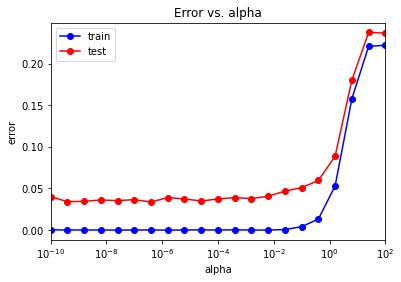

In [42]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

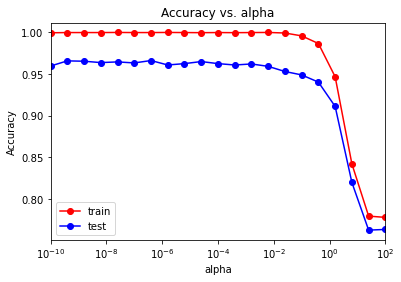

In [43]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

Минимальная ошибка на обучающей выборке и минимальная ошибка на тестовой выборке равны:

In [44]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0 0.0337309749074455


In [45]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[3.98107171e-07]


In [46]:
alpha_opt = alpha_opt[0]

Оптимальное alpha = 3.98107171e-07

### Подберём число нейронов в однослойной нейронной сети

In [47]:
neurons_count_arr = np.array([i for i in range(2, 100+1)])
test_err = []
train_err = []
train_acc = []
test_acc = []

for neurons_count in neurons_count_arr:
    mlp_model = MLPClassifier(alpha=alpha_opt,
                              hidden_layer_sizes = (neurons_count,),
                              solver = 'lbfgs', 
                              activation = 'logistic',
                              max_iter=2000,
                              random_state = 33)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

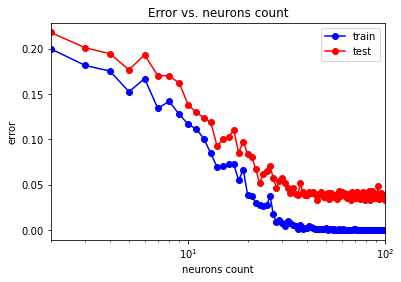

In [48]:
plt.semilogx(neurons_count_arr, train_err, 'b-o', label = 'train')
plt.semilogx(neurons_count_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(neurons_count_arr), np.max(neurons_count_arr)])
plt.title('Error vs. neurons count')
plt.xlabel('neurons count')
plt.ylabel('error')
plt.legend()

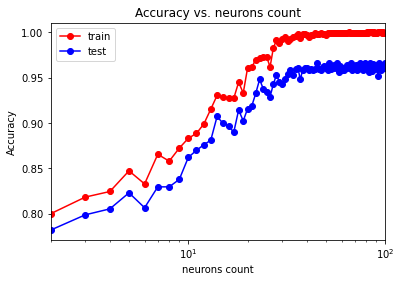

In [49]:
plt.semilogx(neurons_count_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(neurons_count_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(neurons_count_arr), np.max(neurons_count_arr)])
plt.title('Accuracy vs. neurons count')
plt.xlabel('neurons count')
plt.ylabel('Accuracy')
plt.legend()

Минимальная ошибка на обучающей выборке и минимальная ошибка на тестовой выборке равны:

In [50]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0 0.03331962155491567


In [51]:
neuro_opt = neurons_count_arr[test_err == min_test_err][0]
print(neuro_opt)

79


Оптимальное число нейронов = 79

## Повторное обучение нейронной сети с оптимальными параметрами.

In [52]:
mlp_model1 = MLPClassifier(activation = "logistic", solver="lbfgs", alpha = alpha_opt,
                           hidden_layer_sizes = (neuro_opt, ), max_iter=2000, random_state = 33)

In [53]:
mlp_model1.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=3.981071705534969e-07,
              hidden_layer_sizes=(79,), max_iter=2000, random_state=33,
              solver='lbfgs')

In [54]:
y_test_predict1 = mlp_model1.predict(X_test)
err_test1 = np.mean(y_test != y_test_predict1)
err_test1

0.03331962155491567

In [55]:
y_train_predict1 = mlp_model1.predict(X_train)
err_train1 = np.mean(y_train != y_train_predict1)
err_train1

0.000274310794129749

Матрица рассогласования:

In [56]:
print(confusion_matrix(y_test_pred, y_test))

[[1158    0]
 [  82 1191]]


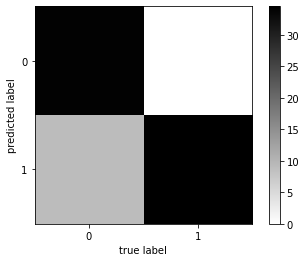

In [57]:
M = confusion_matrix(y_test_pred, y_test)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(2))
plt.yticks(range(2))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

Диагональные элементы матрицы рассогласования отвечают за число случаев, когда сеть правильно предсказала класс объекта. В данной матрице эти случаи доминируют, следовательно, обучение прошло успешно.

# Вывод:

    В ходе работы была обучена однослойная нейронная сеть. Были найдены оптимальное значение alpha = 3.98107171e-07 и оптимальное количество нейронов = 79 для наиболее успешного обучения. Переобучение и недообучение не наблюдаются.